# CA : reproduce Chelsea's fitting with **linmix**

I take Chelsea's IDL  code, `s82drw_mlinmixerr.pro`. It uses  `mlinmix_err2`, which is the modified version (I think) of Brandon Kelly's `mlinmix_err` from 2006 ( https://idlastro.gsfc.nasa.gov/ftp/pro/math/mlinmix_err.pro ) . The other routine authored by B. Kelly -  `linmix_err`, seems to be more recent, with updates all the way to 2011 - very similar callsign, etc. ( https://idlastro.gsfc.nasa.gov/ftp/pro/math/linmix_err.pro ).  

Josh Meyers took  the `linmix_err` and ported it to python, creating the `linmix` package (  https://github.com/jmeyers314/linmix and https://linmix.readthedocs.io/en/latest/example.html ).  

I first use Chelsea's data and attempt to reproduce her IDL code with `linmix` in python to verify that I can reproduce her fit coefficients from Table 1 MacLeod2010.  

In [16]:
import linmix
import numpy as np 
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib import rcParams
from astropy.table import Table
from astropy.table import vstack
from astropy.table import Column
import os
import scipy
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18


## TOC : <a id='toc'></a>
    
   * [store s82drw-shen2011 in IDL format](#s82IDL)
   * [read IDL results MLINMIX_ERR/2](#readIDL)
   * [fit with linmix](#linmix)

In [3]:
# Read in Chelsea's data ...
# Use the result of reading her data band by band,  
# keeping only those where:
# Npts  > 10 , Plike - Pnoise  > 2 , Plike - Pinf > 0.05 ,  edge == 0 

# calculating lambdaRF = lambdaOBS / (1+redshift)
# calculating SFinf  = np.power(10, log10sigmahat) * sqrt(np.power(10, log10tau / 365.)  
# calculating tauRF = np.power(10,log10tau  / (1.+ redshift)
# calculating 4000 A values : 
#   SFinf4000 =  SFinf  * np.power(4000 / lambdaRF , -0.479)
#   tau4000 =  tauRF * np.power(4000 /  lambdaRF  , 0.17 )
# cross-matching to Shen2011, with DR7 data,
# adding to each band updated M_BH 



# Store s82drw in IDL-readable format <a id='s82IDL'></a>


In [17]:
# a dictionary of five filters .... 
s82 = np.load('s82drw_shen2011_dbqso_dic.npy').item()

# Save in a format readable by IDL , 
# saving only 
# var: variance in mag^2, equal to sigmahat^2*tau/365 = SF_inf^2 
#;   tau: log(tau), where tau is best-fit timescale in days
#;   lRF: rest-frame wavelength in Angstroms
#;   M_i_corr: Absolute Magnitude M_i, K-corrected to z=0
#;   mass_bh: BH mass in log solar masses
#;   redshift
# band : number 1 to 5 corresponding to ugriz 



In [23]:
np.log10(s82['r']['redshift'] - s82['r']['REDSHIFT'])

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


nan
nan
nan
-3.9999797058748117
nan
nan
-2.8860607894678294
-2.4089356478508126
-1.946920596216939
-3.096933621652812
-2.7958936853503986


(array([  49.,   87.,  160.,  424., 5337.,  415.,  159.,   76.,   43.,
          30.]),
 array([-0.004 , -0.0031, -0.0022, -0.0013, -0.0004,  0.0005,  0.0014,
         0.0023,  0.0032,  0.0041,  0.005 ]),
 <a list of 10 Patch objects>)

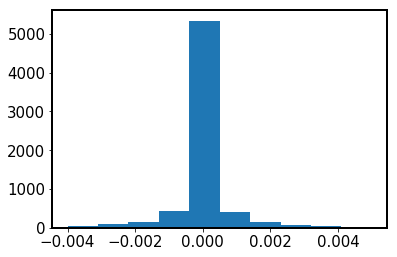

In [35]:
plt.hist(np.log10(s82['r']['redshift']/ s82['r']['REDSHIFT']), range=(-.004,.005))

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([  0., 424., 550., 691., 612., 319., 248., 118.,  43.,   1.]),
 array([-4.5 , -4.15, -3.8 , -3.45, -3.1 , -2.75, -2.4 , -2.05, -1.7 ,
        -1.35, -1.  ]),
 <a list of 10 Patch objects>)

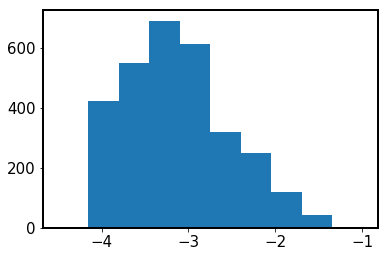

In [40]:
plt.hist(np.log10(s82['r']['redshift'] -  s82['r']['REDSHIFT']), range=(-4.5,-1))

tiny differences : less than 0.01 ... So the fact that for Chelsea fitting I used MI_Z2,  Shen2011 LOGBH,  but Shen2008 (DBQSO) redshift ,  shouldn't be a big deal  ( in /line5_MI_Z2/ ) 

In /line5_celerite_MI_Z2/ I'm using all qualities from Shen2011:  MI_Z2,  LOGBH , REDSHIFT 

In [21]:


# add column with band 
for f, i in zip('ugriz', [1,2,3,4,5]):
    s82[f]['band'] = i
    
cols = ['ra','dec', 'SFinf', 'log10tau', 'lambdaRF', 'M_i', 'M_i_corr', 'MI_Z2', 
    'mass_BH', 'LOGBH','redshift', 'band']

stacked = vstack([s82[f][cols] for f in 'ugriz'])# s82['u'][cols], s82['g'][cols])

# change some colnames to reflect what they contain
stacked.rename_column('LOGBH', 'mass_BH_Shen2011')

#store only one band for test 
#s82['u'][cols].write('s82drw_u_test.txt', format='ascii', overwrite='True',comment=False)

# store all
stacked.write('s82drw_ugriz.txt', format='ascii',overwrite='True',comment=False)

In [23]:
Table.read('s82drw_ugriz.txt', format='ascii')

ra,dec,SFinf,log10tau,lambdaRF,M_i,M_i_corr,MI_Z2,mass_BH,mass_BH_Shen2011,redshift,band
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
2.169302,1.238649,0.09831540391013008,1.9955,1698.0221900627112,-23.901,-24.181,-24.28560773968867,0.0,7.523330610633552,1.073,1
1.091028,0.962126,0.3398580551150435,2.27673,1970.1124979011586,-23.399,-23.576,-23.96421289067481,0.0,8.817950339204,0.7867,1
0.331289,0.17723,0.21759733283957713,1.87484,1343.5627314019619,-24.735,-25.058,-25.008960685706665,0.0,8.921718166686233,1.6199,1
1.364696,-0.098956,0.364546193475551,2.47534,2182.9457364341083,-23.121,-24.045,-24.03915568655799,0.0,9.022211072036765,0.6125,1
0.221552,-0.292485,0.11250596983818298,1.70714,937.0923515161196,-26.451,-26.974,-26.916981368954627,9.361,9.249395337439456,2.7563,1
0.28137,0.686984,0.24474147199702426,2.62304,1467.4003668500916,-24.917,-25.288,-25.23082414221863,8.817,8.779701698389463,1.3988,1
2.607954,0.913245,0.34534213353974985,3.23382,914.9273516492085,-27.263,-27.856,-27.80633729514747,0.0,9.161108417887768,2.8473,1
1.669492,0.643952,0.30229611635955245,2.22321,1505.3671470726595,-24.427,-24.898,-24.738376414675884,8.666,8.58543659024028,1.3383,1
4.850273,-0.276395,0.20377859697231657,2.58011,1271.2170458649332,-25.251,-25.695,-25.535346152682955,0.0,9.122054257696913,1.769,1


# Show IDL results (A,C,D: MLINMIX_ERR) <a id='readIDL'></a>

First for SF_inf ...

In [44]:
mlinmix_diff = {}

Results for  SF
1 mean A= -0.47516608244115915
1 mean C= 0.12207877338945022
1 mean D= 0.14811451173144377
2 mean A= -0.44811253773093757
2 mean C= 0.12718306430052495
2 mean D= 0.1451527604077876
3 mean A= -0.48920405041816284
3 mean C= 0.11734994760452622
3 mean D= 0.11976867053250172
4 mean A= -0.48581444898003284
4 mean C= 0.12265063725144242
4 mean D= 0.11583378556857163
5 mean A= -0.478172121382365
5 mean C= 0.12032661340320921
5 mean D= 0.10978183889787496
Band-averaged A =  -0.4752938481905315
Band-averaged C =  0.12191780718983061
Band-averaged D =  0.12773031342763594


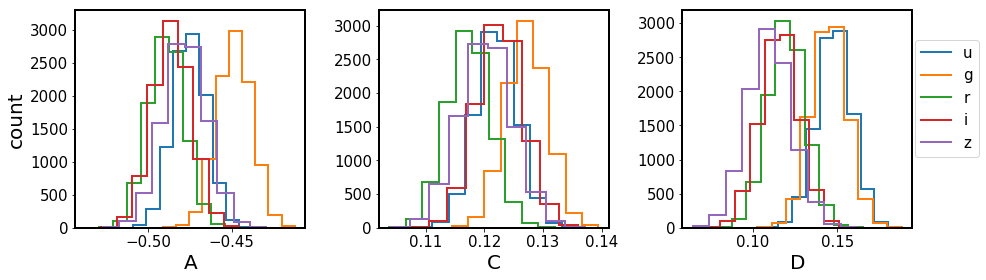

In [15]:
# Read in the results of MLINMIX_ERR fitting ....
%matplotlib inline
import matplotlib.lines as mlines
import seaborn as sns 
current_palette = sns.color_palette()

# this used M_i from s82drw 
fig,ax = plt.subplots(1,3, figsize=(15,4))
A=[]; C=[]; D=[]
b = 'ugriz'
par = 'SF'#'tau'#'SF'# 'SF'#'tau'#  'SF'#tau' # 'SF' 
lw=2
ax_legend_handles =  []
print('Results for ', par)
for band in range(1,6):
    #d = '../IDL/line5_ACD_M_i/'   # using 'M_i' - K -corrected to z=0 DBQSO
    #d = '../IDL/line5_ACD_M_i_corr/'   # using 'M_i_corr' - K -corrected to z=2 DBQSO
    #d = '../IDL/line5_ACD_MI_Z2_shifted/'     # using 'MI_Z2 + 0.596  - K-corrected to z=0 
    d = '../IDL/line5_ACD_MI_Z2/'  # using MI_Z2  - K-corrected to z=2 
    #d = '../IDL/mlinmixerr2_line5_ACD_MI_Z2/' # using 'MI_Z2', k-corr to z=2, 
                                            # but with mlinmix_err2
    #d = '../IDL/mlinmixerr2_line5_ACD_M_i/'# using 'M_i" k-corr to z=0
    f = 'coeff'+par+'o_mcmc2_'+str(band)+'_E0a.fits'
    post = Table.read(d+f, format='fits')
    
    c = current_palette[band-1]
    
    ax[0].hist(post['ALPHA'],histtype='step',color=c,lw=lw)
    A.append(np.mean(post['ALPHA']))
    print(band, 'mean A=', np.mean(post['ALPHA']))
    
    ax[1].hist(post['BETA'][:,0],histtype='step',color=c,lw= lw)
    print(band, 'mean C=', np.mean(post['BETA'][:,0]))
    C.append(np.mean(post['BETA'][:,0]))
    
    ax[2].hist(post['BETA'][:,1],histtype='step',color=c,lw=lw )
    print(band, 'mean D=', np.mean(post['BETA'][:,1]))
    D.append(np.mean(post['BETA'][:,1]))
    
    line = mlines.Line2D([], [],  color=c, label=b[band-1],lw=lw)
    ax_legend_handles.append(line)
    
ax[0].set_ylabel('count')
ax[0].set_xlabel('A')
ax[1].set_xlabel('C')
ax[2].set_xlabel('D')
ax[2].legend(loc='upper left', handles = ax_legend_handles,
             bbox_to_anchor=(0.98, 0.9), fontsize=15,fancybox=True)
fig.subplots_adjust(wspace=0.32)

print('Band-averaged A = ', np.mean(A))
print('Band-averaged C = ', np.mean(C))
print('Band-averaged D = ', np.mean(D))
#mlinmix_diff['mlinmix3'] = [np.mean(A), np.mean(C), np.mean(D)]


In [47]:
np.save('mlinmix_tau_difference',mlinmix_diff)

In [48]:
mlinmix_diff

{'mlinmix': [2.5832780941356246, -0.05664058135777158, 0.19670009395557408],
 'mlinmix3': [2.5831893347920802, -0.05667034952632993, 0.1966431124711429]}

In [36]:
MI_Z2

{'mlinmix': [-0.4401318040076346, 0.13338145307136656, 0.1795765111733974],
 'mlinmix2': [-0.4400808265252566, 0.1334085782026972, 0.1795616596196065]}

# Use linmix to fit for A,C (setting D to 0 )  <a id='linmix'></a>

In [4]:
# a dictionary of five filters .... 
s82 = np.load('s82drw_shen2011_dbqso_dic.npy').item()
s82['u'][:10]


SDR5ID,ra,dec,redshift,M_i,mass_BH,chi2_pdf,log10tau,log10sigmahat,log10tau_lim_lo,log10tau_lim_hi,log10sigmahat_lim_lo,log10sigmahat_lim_hi,edge,Plike,Pnoise,Pinf,mu,Npts,lambdaRF,SFinf,tauRF,SFinf4000,tau4000,d2d_asec_Shen11,SDSS_NAME,RA,DEC,REDSHIFT,LOGLBOL,LOGBH,LOGBH_ERR,LOGEDD_RATIO,MI_Z2,d2d_asec_DBQSO,M_i_corr
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,bytes18,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
301,2.169302,1.238649,1.073,-23.901,0.0,0.968284,1.9955,-0.723982,1.53265,3.72459,-1.23257,-0.584464,0,94.7333,90.6945,92.8552,20.7869,60,1698.0221900627112,0.09831540391013008,47.742009834496045,0.0652195355955333,55.228153722153294,0.014948619064117841,000840.63+011419.1,2.1693060398101807,1.2386499643325806,1.073699951171875,45.52781425110629,7.523330610633552,1.5230929717266002,-0.09588690464482141,-24.28560773968867,0.0,-24.181
144,1.091028,0.962126,0.7867,-23.399,0.0,1.14117,2.27673,-0.325921,2.08917,4.02532,-0.510504,-0.261182,0,63.9319,42.5078,62.2803,20.7824,47,1970.1124979011586,0.3398580551150435,105.84695349396134,0.2420873148515182,119.38921225751962,0.008160006786109475,000421.84+005743.6,1.0910290479660034,0.9621239900588989,0.792900025844574,45.421472462631726,8.817950339204,0.1672667771274661,-1.4968484216898403,-23.96421289067481,0.0,-23.576
58,0.331289,0.17723,1.6199,-24.735,0.0,1.23288,1.87484,-0.31862,1.62701,3.0311,-0.636571,-0.236789,0,72.3127,61.8195,69.3966,20.5453,53,1343.5627314019619,0.21759733283957713,28.61246570406551,0.12903347377913088,34.44305240052322,0.007186574652845284,000119.50+001038.0,0.33128899335861206,0.17722800374031067,1.62090003490448,45.95221191379889,8.921718166686233,0.20424216150370847,-1.0698767980049055,-25.008960685706665,0.0,-25.058
190,1.364696,-0.098956,0.6125,-23.121,0.0,1.0239,2.47534,-0.394771,2.32222,4.21751,-0.522501,-0.354452,0,99.8258,56.6434,98.5452,19.8859,57,2182.9457364341083,0.364546193475551,185.28500633684095,0.2727516586369636,205.3776477218901,0.010821882163806102,000527.52-000556.2,1.3646990060806274,-0.09895599633455276,0.6123999953269958,45.39391039241853,9.022211072036765,0.2674947222920013,-1.7286712247357983,-24.03915568655799,0.0,-24.045
36,0.221552,-0.292485,2.7563,-26.451,9.361,1.10691,1.70714,-0.521248,1.28728,3.6222,-1.09609,-0.386069,0,81.792,78.9905,79.9715,20.6848,55,937.0923515161196,0.11250596983818298,13.563748539736254,0.05614002455760786,17.359088665217733,0.023050764668535072,000053.17-001732.9,0.22155599296092987,-0.29249000549316406,2.7571001052856445,46.78928392693668,9.249395337439456,0.05766163885177335,-0.5604819556203395,-26.916981368954627,0.0,-26.974
49,0.28137,0.686984,1.3988,-24.917,8.817,0.748652,2.62304,-0.641666,2.48696,4.32531,-0.750577,-0.597245,0,124.681,63.373,123.61,20.0128,59,1467.4003668500916,0.24474147199702426,175.00318784502468,0.15139015111738424,207.530958735004,0.02101275011528123,000107.52+004113.1,0.2813670039176941,0.6869890093803406,1.3990000486373901,46.03569644938995,8.779701698389463,0.10077066846943966,-0.8443757941170773,-25.23082414221863,0.0,-25.288
370,2.607954,0.913245,2.8473,-27.263,0.0,1.00762,3.23382,-0.797514,2.89732,4.5885,-0.964445,-0.654236,0,66.2818,52.3143,66.1312,21.2105,54,914.9273516492085,0.34534213353974985,445.3115376609138,0.17035975961027092,572.2402768592847,0.006957001187532509,001025.90+005447.6,2.6079559326171875,0.9132450222969055,2.857300043106079,46.84894590389279,9.161108417887768,0.06073325470830668,-0.41253305911254046,-27.80633729514747,0.0,-27.856
229,1.669492,0.643952,1.3383,-24.427,8.666,0.940847,2.22321,-0.350026,2.01398,3.51335,-0.492537,-0.289666,0,88.2909,55.0468,85.9202,20.7157,61,1505.3671470726595,0.30229611635955245,71.50061385002057,0.18929387327460825,84.42299498899229,0.004962043940038134,000640.67+003838.2,1.6694910526275635,0.6439509987831116,1.3370000123977661,

In [5]:
A = [] ;  C = [] 

for band in 'ugriz':
    print(band, ' band ')
    var = s82[band]['SFinf'].data ** 2.0  # variance in mag^2, equal to sigmahat^2*tau/365 = SF_inf^2 
    redshift = s82[band]['redshift'].data
    tauOBS  = s82[band]['log10tau'].data # NOTE : log10tau is observed frame !!!! 
    tau = tauOBS-np.log10(1.0+redshift) # correct to rest frame .... 
    # where tau is best-fit rest frame timescale in days
    lRF = s82[band]['lambdaRF'].data # rest-frame wavelength in Angstroms
    #M_i_corr = s82[band]['MI_Z2'].data #+ 0.596 
    M_i_corr = s82[band]['M_i'].data 
    # ??? in reality, M_i is uncorrected, ???
    # M_i_corr is K-corrected to z=2 , like MI_Z2 
    # Absolute Magnitude M_i, K-corrected to z=0
    mass_bh = s82[band]['mass_BH'].data #  BH mass in log solar masses
    

    select = mass_bh > 0 
    print('Of ', len(select), ' quasars in that band, ',select.sum() , ' have M_BH')
    f = np.log10(np.sqrt(var))[select]  # SF_inf array
    x = np.log10(lRF/4000.)[select]     # Rest-wavelength array
    y = (M_i_corr+23.)[select]          # Absolute Magnitude M_i, K-corrected to z=0
    z = (mass_bh-9.)[select]            # BH mass in 10^9 solar masses
    red = np.log10(1.+redshift)[select]  #  redshift array; not needed

    # First, remove wavelength trend: 
    lampwrsf = - 0.479
    fo = f - lampwrsf*x 

    # Set up matrix containing BH mass errors:
    sigma_lum = 1e-5 #(set arbitrarily small)
    sigma_mbh = 0.2 # BH mass errors in dex
    sigma_z = 1e-5  # (set arbitrarily small)


    ### OBSOLETE : translation from IDL to Python , but 
    ### MLINMIX_ERR is not available in python anyways ... 
    #xdata = [[y],[z]]  # E==0  (use for Final model)
    #xdata = [[y],[z],[red]]
    #pars = [1,0.024,.05]      # Parameters are [A,C,D] (E is fixed to zero)
    #pars = [1,0.024,.05,.05] ; Parameters are [A,C,D,E] (not using)
    #npars = len(pars)

    #xvar = np.zeros((len(f),npars-1,npars-1))
    #for ic in range(len(f)-1):
        # https://www.harrisgeospatial.com/docs/DBLARR.html
     #   xvar[ic,:,:] = [[sigma_lum**2., 0], [0, sigma_mbh**2.]] 

    #yvar = np.zeros(len(fo))+0.01**2.

    x1 = y  ; #x2 = z
    y1 = fo
    sigx1 = sigma_lum;  #sigx2 = sigma_mbh
    sigy1 = 0.01 

    # run the linmix for x1 :  M_i_corr ... 
    lm1 = linmix.LinMix(x=x1, y=y1, xsig=sigx1, ysig=sigy1, K=3)
    lm1.run_mcmc(silent=True)

    # store the MCMC chains 
    np.save('linmix_AC_chains_M_i_'+band , lm1.chain[:])

    a = lm1.chain[:]['alpha']
    alpha1 = np.mean(a)
    alpha1_err = np.std(a)

    b = lm1.chain[:]['beta']
    beta1 = np.mean(b)
    beta1_err = np.std(b)

    print('alpha = ', alpha1, ' +/- ', alpha1_err)
    print('beta = ', beta1, ' +/- ', beta1_err)

    A.append(alpha1)
    C.append(beta1)

u  band 
Of  7014  quasars in that band,  4660  have M_BH
alpha =  -0.6313510312418349  +/-  0.0071151546160630585
beta =  0.07969520397374197  +/-  0.0029653695273611567
g  band 
Of  7408  quasars in that band,  4702  have M_BH
alpha =  -0.622268490260859  +/-  0.007535972802385156
beta =  0.07779552901179852  +/-  0.003071316740927428
r  band 
Of  6871  quasars in that band,  4352  have M_BH
alpha =  -0.6348053455104399  +/-  0.008313377647222356
beta =  0.0784174693302671  +/-  0.003408505681862957
i  band 
Of  6814  quasars in that band,  4338  have M_BH
alpha =  -0.6302445495362851  +/-  0.008069836139361915
beta =  0.08440551634037959  +/-  0.003319559777053146
z  band 
Of  5111  quasars in that band,  3500  have M_BH
alpha =  -0.6247027491457722  +/-  0.00891842720017679
beta =  0.07867958160463388  +/-  0.003710363352942083


In [25]:

print('Band-averaged A = ', np.mean(A))
print('Band-averaged C = ', np.mean(C))

Band-averaged A =  -0.5878894651373583
Band-averaged C =  0.08270811645199164


alpha =  -0.631168936395  +/-  0.00718092107221
beta =  0.0797840604507  +/-  0.00298964048332


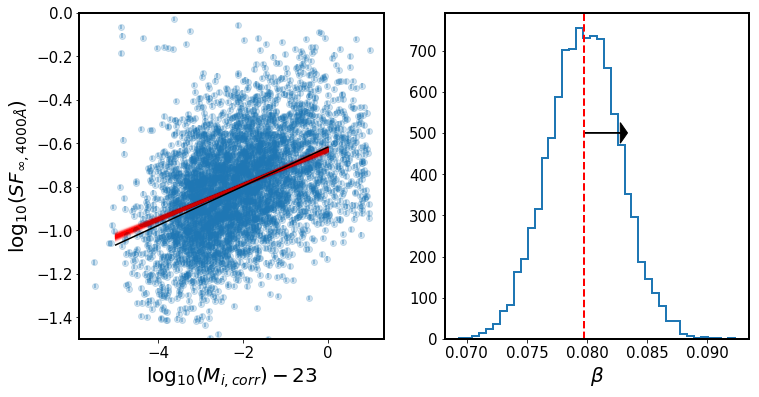

In [179]:
%matplotlib inline 
fig,ax = plt.subplots(1,2,figsize=(12,6))

# x1 = y = (M_i_corr+23.)[select]    
# y1 = fo = f - lampwrsf*x ,    f =  np.log10(SF_inf)

ax[0].scatter(x1, y1, alpha=0.2)
ax[0].errorbar(x1, y1, xerr=sigx1 , yerr=sigy1 , ls=' ', alpha=0.5)

for i in range(0, len(lm.chain), 25):
    xs = np.arange(-5,1)
    ys = lm1.chain[i]['alpha'] + xs * lm1.chain[i]['beta']
    ax[0].plot(xs, ys, color='r', alpha=0.02)

# plot in black Chelsea's slope...
alpha, beta = -0.618, 0.090
ys = alpha + xs * beta
ax[0].plot(xs, ys, color='k')

ax[0].set_xlabel(r'$\log_{10}{(M_{i,corr})} - 23$')
ax[0].set_ylabel(r'$\log_{10}{(SF_{\infty, 4000 \AA})}  $')
ax[0].set_ylim(-1.5,0)
rms = lambda x: np.sqrt(np.mean(np.square(x)))
a = lm1.chain[:]['alpha']
alpha1 = np.mean(a)
alpha1_err = np.std(a)
print('alpha = ', alpha1, ' +/- ', alpha1_err)

# Illustrate beta, and the standard error ... 
b = lm1.chain[:]['beta']
beta1 = np.mean(b)
beta1_err = np.std(b)

ax[1].hist(b, bins=40, histtype='step', lw=2)
ax[1].axvline(beta1, ls='--', c='r', lw=2)
ax[1].arrow(beta1,500, beta1_err, 0.,head_width=50, head_length = 0.2*beta1_err,
         ec='k', fc='k')
ax[1].set_xlabel(r'$\beta$')
print('beta = ', beta1, ' +/- ', beta1_err)

plt.savefig('mcmc_lm1.png', bbox_inches='tight')

In [183]:
# run linmix  for x2 :  M_BH 
lm2 = linmix.LinMix(x=x2, y=y1, xsig=sigx2, ysig=sigy1, K=3)
lm2.run_mcmc(silent=True)



alpha =  -0.813643602695  +/-  0.0039292300339
beta =  -0.119727304653  +/-  0.00298964048332


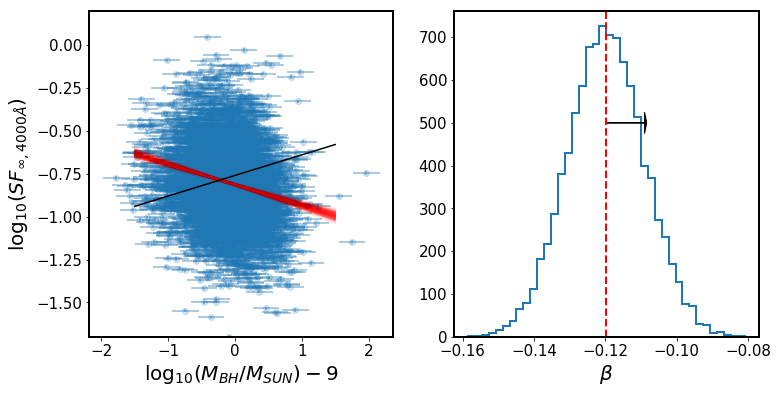

In [180]:
%matplotlib inline 
fig,ax = plt.subplots(1,2,figsize=(12,6))

# x2 = z = (mass_bh-9.)[select]  
# y1 = fo = f - lampwrsf*x ,    f =  np.log10(SF_inf)

ax[0].scatter(x2, y1, alpha=0.2)
ax[0].errorbar(x2, y1, xerr=sigx2 , yerr=sigy1 , ls=' ', alpha=0.5)

# plot some chains .... 
for i in range(0, len(lm.chain), 25):
    xs = np.linspace(-1.5,1.5)
    ys = lm2.chain[i]['alpha'] + xs * lm2.chain[i]['beta']
    ax[0].plot(xs, ys, color='r', alpha=0.02)

alpha, beta =  -0.760, 0.12
ys = alpha + xs * beta
ax[0].plot(xs, ys, color='k')
ax[0].set_xlabel(r'$\log_{10}{(M_{BH} / M_{SUN})} - 9$')
ax[0].set_ylabel(r'$\log_{10}{(SF_{\infty, 4000 \AA})}  $')
ax[0].set_ylim(-1.7,0.2)
rms = lambda x: np.sqrt(np.mean(np.square(x)))
a = lm2.chain[:]['alpha']
alpha2 = np.mean(a)
alpha2_err = np.std(a)
print('alpha = ', alpha2, ' +/- ', alpha2_err)

# Illustrate beta, and the standard error ... 
b = lm2.chain[:]['beta']
beta2 = np.mean(b)
beta2_err = np.std(b)

ax[1].hist(b, bins=40, histtype='step', lw=2)
ax[1].axvline(beta2, ls='--', c='r', lw=2)
ax[1].arrow(beta2,500, beta2_err, 0.,head_width=50, head_length = 0.2*beta1_err,
         ec='k', fc='k')
print('beta = ', beta2, ' +/- ', beta1_err)
ax[1].set_xlabel(r'$\beta$')
plt.savefig('mcmc_lm2.png', bbox_inches='tight')

-0.813504761566 0.00392395556565


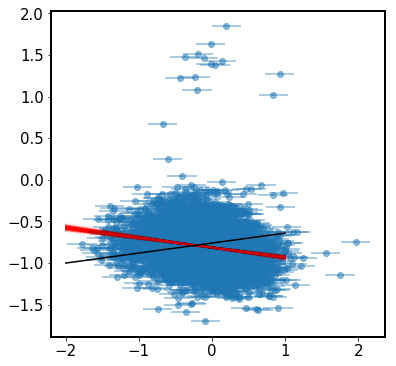

In [164]:
%matplotlib inline 
fig,ax = plt.subplots(1,1,figsize=(6,6))

# y1 = fo = f - lampwrsf*x ,    f =  np.log10(SF_inf)
# x2 = z = (mass_bh-9.)[select]   
ax.scatter(x2, y1, alpha=0.5)
ax.errorbar(x2, y1, xerr=sigx2 , yerr=sigy1 , ls=' ', alpha=0.5)

for i in range(0, len(lm.chain), 25):
    xs = np.arange(-2,2)
    ys = lm2.chain[i]['alpha'] + xs * lm2.chain[i]['beta']
    ax.plot(xs, ys, color='r', alpha=0.02)

alpha, beta = -0.760, 0.12
ys = alpha + xs * beta
ax.plot(xs, ys, color='k')


rms = lambda x: np.sqrt(np.mean(np.square(x)))
alpha2 = np.mean(lm.chain[:]['alpha'])
alpha2_err = np.std(lm.chain[:]['alpha'])
#plt.hist(lm.chain['alpha'])
print(alpha2, alpha2_err)

In [ ]:
linmix.ma